In [1]:
%load_ext autoreload
%autoreload 2
from dds.configs.config import set_task, get_config
from dds.train_dds import train_dds
import numpy as onp
import jax

import distrax
import jax.numpy as jnp
import haiku as hk
from jaxline import utils

import functools
import timeit
from typing import Any, List, Tuple, Optional
from absl import app, flags

from absl import logging
import haiku as hk
import distrax
import jax
import jax.numpy as jnp

from ml_collections import config_dict as configdict
from ml_collections import config_flags

import numpy as onp
import optax

from jaxline import utils

from dds.configs.config import set_task
from dds.data_paths import results_path
from dds.utils import flatten_nested_dict
import wandb
print(jax.devices())

2023-08-17 12:35:52.049080: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2023-08-17 12:35:52.049193: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory
2023-08-17 12:35:52.049201: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Cannot dlopen some TensorRT libraries. If you would like to use Nvidia GPU with TensorRT, please make sure the missing libraries mentioned above are installed properly.


[StreamExecutorGpuDevice(id=0, process_index=0, slice_index=0)]


In [2]:
from dds.objectives import controlled_ais_relative_kl_objective
from dds.objectives import controlled_ais_importance_weighted_partition_estimate_dds


config = get_config()

# Time and step settings (Need to be done before calling set_task)
config.model.tfinal = 6.4
# config.model.tfinal = 10
config.model.dt = 0.05

config.model.reference_process_key = "cais"

config.trainer.objective = controlled_ais_relative_kl_objective
config.trainer.lnz_is_estimator = controlled_ais_importance_weighted_partition_estimate_dds

if config.model.reference_process_key == "oudstl":
    config.model.step_scheme_key = "cos_sq"

config = set_task(config, "funnel")

if config.model.reference_process_key == "oudstl":
    config.model.step_scheme_key = "cos_sq"
    
    # Opt setting for funnel
    config.model.sigma = 1.
    config.model.alpha = 0.6875
    config.model.m = 1.0
        
    # Path opt settings    
    config.model.exp_dds = False

if config.model.reference_process_key == "cais":
    config.model.step_scheme_key = "linear"
    
    # Opt setting for funnel
    config.model.alpha = 0.6875
    config.model.m = 1.0
        
    # Path opt settings    
    config.model.exp_dds = False
    config.trainer.lr_sch_base_dec = 1.0
    config.trainer.learning_rate = 1 * 10**(-5)
    
    if config.task == "funnel": # lnZ: 0.4, ELBO: 1.6
        config.model.sigma = 1.25
        config.model.sigma_base = 1.75
        config.trainer.learning_rate = 1 * 10**(-5)
        config.trainer.lr_sch_base_dec = 0.95 # For funnel
        
    if config.task == "lr_sonar":
        config.model.sigma = 0.5
        config.model.sigma_base = 0.6
    
    if config.task == "ion":
        config.model.sigma = 0.5
        config.model.sigma_base = 0.7
    
    if config.task == "lgcp":  # lnZ: 473, ELBO: 413
        config.model.sigma = 4.6
        config.model.sigma_base = 2.3
    


config.model.stl = False
config.model.detach_stl_drift = False

config.trainer.notebook = True
config.trainer.epochs = 200  #  11000
# Opt settings we use
# funnel_config.trainer.learning_rate = 0.0001
# config.trainer.learning_rate = 5 * 10**(-3)

config.model.reference_process_key = "cais"
# config.trainer.learning_rate = 0
config.trainer.epochs = 6000
# config.trainer.epochs = 1
config.model.sigma, config.model.sigma_base

(1.25, 1.75)

In [3]:
config.trainer.epochs

6000

In [4]:
def update_detached_params(trainable_params, non_trainable_params,
                           attached_network_name="simple_drift_net",
                           detached_network_name="stl_detach"):
  """Auxiliary function updating detached params for STL.

  Args:
      trainable_params:
      non_trainable_params:
      attached_network_name:
      detached_network_name:
  Returns:
    Returns non trainable params
  """

  if len(trainable_params) != len(non_trainable_params):
    return non_trainable_params

  for key in trainable_params.keys():
    if attached_network_name in key:
      key_det = key.replace(attached_network_name, detached_network_name)
    else:
      key_det = key.replace("diffusion_network",
                            detached_network_name + "_diff")
    non_trainable_params[key_det] = trainable_params[key]  # pytype: disable=unsupported-operands

  return non_trainable_params

data_dim = config.model.input_dim
device_no = jax.device_count()

results_path = '~/denoising_diffusion_samplers/results'
alpha = config.model.alpha
sigma = config.model.sigma
m = config.model.m

if config.model.reference_process_key == "oudstl":
    config.model.sigma_base = config.model.sigma

# post setup model vars
config.model.source_obj = distrax.MultivariateNormalDiag(
    jnp.zeros(config.model.input_dim),
    config.model.sigma_base * jnp.ones(config.model.input_dim))
config.model.source = config.model.source_obj.log_prob

batch_size_ = int(config.model.batch_size / device_no)
batch_size_elbo = int(config.model.elbo_batch_size / device_no)

step_scheme = config.model.step_scheme_dict[config.model.step_scheme_key]

dt = config.model.dt

if config.model.reference_process_key == "oududp":
    key_conversion = {
        "pis": "pisudp",
        "vanilla": "vanilla_udp",
        "tmpis": "tmpis_udp"
    }
    # "pisudp"
    config.model.network_key = key_conversion[config.model.network_key]

net_key = config.model.network_key
network = config.model.network_dict[net_key]

tpu = config.model.tpu

detach_dif_path, detach_dritf_path = (
    config.model.detach_path, config.model.detach_path)

target = config.model.target

tfinal = config.model.tfinal
lnpi = config.trainer.lnpi

ref_proc_key = config.model.reference_process_key
ref_proc = config.model.reference_process_dict[ref_proc_key]

trim = (2 if "stl" in str(ref_proc).lower() or "udp" in str(ref_proc).lower()
        else 1)

stl = config.model.stl

brown = "brown" in str(ref_proc).lower()

seed = config.trainer.random_seed  if "random_seed" in config.trainer else 42

# task directory (currently not in use)
task = config.task
method = config.model.reference_process_key
task_path = results_path + f"/{task}" + f"/{ref_proc_key}" + f"/{net_key}"
task_path += f"/{method}"


# checkpoiting variables for wandb
nsteps = config.model.ts.shape[0]
keep_every_nth = int(config.trainer.epochs / 125)
file_name = (f"/alpha_{alpha}_sigma_{sigma}_epochs_{config.trainer.epochs}" +
            f"_task_{task}_seed_{seed}_steps_{nsteps}_stl_{stl}_{method}" +
            f"_scheme_{config.model.step_scheme_key}_ddpm_test11_chk")
_ = task_path + file_name

detach_stl_drift = (
    config.model.detach_stl_drift if
    "detach_stl_drift" in config.model else False
)

drift_network = lambda: network(config.model, data_dim, "simple_drift_net")

############## wandb logging  place holder ################
data_id = "denoising_diffusion_samplers"  # Project name

In [5]:
from turtle import forward


def _forward_fn(batch_size: int,
                training: bool = True,
                ode=False, exact=False, dt_=dt) -> jnp.ndarray:

    model_def = ref_proc(
        sigma, 
        data_dim, 
        drift_network, 
        tfinal=tfinal, 
        dt=dt_,
        step_scheme=step_scheme, 
        alpha=alpha, 
        target=target, 
        tpu=tpu,
        detach_stl_drift=detach_stl_drift, 
        diff_net=None,
        detach_dritf_path=detach_dritf_path, 
        detach_dif_path=detach_dif_path,
        m=m, 
        log=config.model.log, 
        exp_bool=config.model.exp_dds, 
        exact=exact
    )

    return model_def(batch_size, training, ode=ode)

forward_fn = hk.transform_with_state(_forward_fn)  

print(forward_fn)


TransformedWithState(init=<function transform_with_state.<locals>.init_fn at 0x7f61c3af7a30>, apply=<function transform_with_state.<locals>.apply_fn at 0x7f61c3af7be0>)


In [6]:
# opt and loss setup
seq = hk.PRNGSequence(seed)
rng_key = next(seq)
# subkeys = jax.random.split(rng_key, device_no)
subkeys = utils.bcast_local_devices(rng_key)

p_init = jax.pmap(
    functools.partial(forward_fn.init, batch_size=batch_size_,
                        training=True), axis_name="num_devices")

params, model_state = p_init(subkeys)

trainable_params, non_trainable_params = hk.data_structures.partition(
    lambda module, name, value: "stl_detach" not in module, params)

clipper = optax.clip(1.0)
base_dec = config.trainer.lr_sch_base_dec
scale_by_adam = optax.scale_by_adam()
# if base_dec == 0:
#   scale_by_lr = optax.scale(-config.trainer.learning_rate)
#   opt = optax.chain(clipper, scale_by_adam, scale_by_lr)
# else:
transition_steps = 50
exp_lr = optax.exponential_decay(config.trainer.learning_rate,
                                transition_steps, base_dec)
scale_lr = optax.scale_by_schedule(exp_lr)
opt = optax.chain(clipper, scale_by_adam, scale_lr, optax.scale(-1))

# opt = optax.adam(learning_rate=config.trainer.learning_rate)
opt_state = jax.pmap(opt.init)(trainable_params)

@functools.partial(
    jax.pmap, axis_name="num_devices", static_broadcasted_argnums=(3, 4, 5, 6))
def forward_fn_jit(
    params,
    model_state: hk.State,
    subkeys: jnp.ndarray,
    batch_size: jnp.ndarray, ode=False, exact=False,  dt_=dt):

    samps, _ = forward_fn.apply(
        params,
        model_state,
        subkeys,
        int(batch_size / device_no),
        False,
        ode=ode, exact=exact, dt_=dt_)
    samps = jax.device_get(samps)

    augmented_trajectory, ts = samps
    return (augmented_trajectory, ts), _

def forward_fn_wrap(
    params,
    model_state: hk.State,
    rng_key: jnp.ndarray,
    batch_size: jnp.ndarray, ode=False, exact=False, dt_=dt):
    subkeys = jax.random.split(rng_key, device_no)
    (augmented_trajectory, ts), _ = forward_fn_jit(params, model_state,
                                                subkeys, batch_size, ode, exact,
                                                dt_)

    dv, ns, t, _ = augmented_trajectory.shape
    augmented_trajectory = augmented_trajectory.reshape(dv*ns, t, -1)
    return (augmented_trajectory, utils.get_first(ts)), _

In [7]:
def full_objective(
    trainable_params,
    non_trainable_params,
    model_state: hk.State,
    rng_key: jnp.ndarray,
    batch_size: int,
    is_training: bool = True,
    ode: bool = False,
    stl: bool = False,
    exact: bool = False,
  ):

  params = hk.data_structures.merge(trainable_params, non_trainable_params)
  (augmented_trajectory, _), model_state = forward_fn.apply(
      params, model_state, rng_key, batch_size, True, ode, exact
  )

  # import pdb; pdb.set_trace()
  gpartial = functools.partial(
      config.model.terminal_cost,
      lnpi=lnpi, sigma=sigma, tfinal=tfinal, brown=brown)
  
  if is_training:
    loss = config.trainer.objective(
        augmented_trajectory, gpartial, source=config.model.source, target=config.model.target, stl=stl, trim=trim, dim=data_dim)
  elif not ode:
    loss = config.trainer.lnz_is_estimator(
        augmented_trajectory, gpartial, source=config.model.source, target=config.model.target, dim=data_dim)
  else:
    loss = config.trainer.lnz_pf_estimator(
        augmented_trajectory, config.model.source, config.model.target)
  return loss, model_state

@functools.partial(
    jax.pmap, axis_name="num_devices", static_broadcasted_argnums=(5,))
def update(
    trainable_params,
    non_trainable_params,
    model_state: hk.State,
    opt_state: Any,
    rng_key: jnp.ndarray,
    batch_size: jnp.ndarray):
  grads, new_model_state = jax.grad(
      full_objective, has_aux=True)(
          trainable_params,
          non_trainable_params,
          model_state,
          rng_key,
          batch_size,
          is_training=True,
          stl=stl)
  grads = jax.lax.pmean(grads, axis_name="num_devices")

  updates, opt_state = opt.update(grads, opt_state)
  new_params = optax.apply_updates(trainable_params, updates)
  return new_params, opt_state, new_model_state

@functools.partial(
    jax.pmap, axis_name="num_devices", static_broadcasted_argnums=(4, 5, 6, 7))
def jited_val_loss(
    trainable_params,
    non_trainable_params,
    model_state: hk.State,
    rng_key: jnp.ndarray,
    batch_size: jnp.ndarray,
    is_training: bool = True,
    ode: bool = False,
    exact: bool = False,):

  loss, new_model_state = full_objective(
      trainable_params,
      non_trainable_params,
      model_state,
      rng_key,
      batch_size,
      is_training=is_training, ode=ode,
      stl=False, exact=exact,)

  loss = jax.lax.pmean(loss, axis_name="num_devices")
  return loss, new_model_state

def eval_report(
    trainable_params,
    non_trainable_params,
    model_state: hk.State,
    rng_key: jnp.ndarray,
    batch_size: int,
    epoch: int,
    loss_list: List[float],
    is_training: bool = True,
    print_flag: bool = False,
    ode: bool = False,
    exact: bool = False,
    wandb_run=None,
    wandb_key: Optional[str] = None,
) -> None:

  loss, model_state = jited_val_loss(
      trainable_params, non_trainable_params,
      model_state, rng_key, batch_size, is_training, ode, exact)
  loss = jax.device_get(loss)
  loss = onp.asarray(utils.get_first(loss).item()).item()

  log_string = "epoch: %s %s  loss: %s", epoch, "TRAIN", loss
  logging.info(log_string)
  if config.trainer.notebook and print_flag: print(log_string)

  loss_list.append(loss)
  if wandb_run:
    wandb_run.log({f"{wandb_key}/epoch": epoch, f"{wandb_key}/loss": loss})
  # writer.flush()

loss_list = []
loss_list_is = []
loss_list_pf = []

start = 0
times = []

run = None

for epoch in range(start, config.trainer.epochs):
  rng_key = next(seq)
  subkeys = jax.random.split(rng_key, device_no)
  
  if epoch == 0:
      eval_report(trainable_params, non_trainable_params,
                    model_state, subkeys, batch_size_elbo, epoch - 1,
                    loss_list, print_flag=True, wandb_run=run, wandb_key="elbo_results")
  if config.trainer.epochs == 1:
    break

  trainable_params, opt_state, model_state = update(trainable_params,
                                                    non_trainable_params,
                                                    model_state, opt_state,
                                                    subkeys, batch_size_)
  if config.trainer.timer:
    def func():
      return jax.block_until_ready(
          update(trainable_params, non_trainable_params, model_state,
                opt_state, subkeys, batch_size_))

    delta_time = timeit.timeit(func, number=1)
    times.append(delta_time)

  update_detached_params(trainable_params, non_trainable_params,
                        "simple_drift_net", "stl_detach")

  if epoch % config.trainer.log_every_n_epochs == 0:

    eval_report(trainable_params, non_trainable_params,
                model_state, subkeys, batch_size_elbo, epoch,
                loss_list, print_flag=True, wandb_run=run, wandb_key="elbo_results")

    eval_report(trainable_params, non_trainable_params,
                model_state, subkeys, batch_size_elbo, epoch,
                loss_list_is, is_training=False, wandb_run=run, wandb_key="is_results")

    eval_report(trainable_params, non_trainable_params,
                model_state, subkeys, batch_size_elbo, epoch,
                loss_list_pf, is_training=False, ode=True, wandb_run=run, wandb_key="pf_results")

    lr = onp.asarray(exp_lr(epoch).item()).item()
    if run:
        run.log({"lr/epoch": epoch, "lr/lr": lr})

print("TRAINING COMPLETED")
loss_list_is_eval, loss_list_eval, loss_list_pf_eval = [], [], []
for i in range(config.eval.seeds):
  rng_key = next(seq)
  subkeys = jax.random.split(rng_key, device_no)
  eval_report(
      trainable_params,
      non_trainable_params,
      model_state,
      subkeys,
      batch_size_elbo,
      i,
      loss_list_eval,
      print_flag=True,
      wandb_run=run,
      wandb_key="elbo_results_eval",)

  eval_report(
      trainable_params,
      non_trainable_params,
      model_state,
      subkeys,
      batch_size_elbo,
      i,
      loss_list_is_eval,
      is_training=False,
      wandb_run=run,
      wandb_key="is_results_eval",)

  eval_report(
      trainable_params,
      non_trainable_params,
      model_state,
      subkeys,
      batch_size_elbo,
      i,
      loss_list_pf_eval,
      is_training=False, ode=True, exact=False,
      wandb_run=run,
      wandb_key="pf_results_eval",)

params = hk.data_structures.merge(trainable_params, non_trainable_params)
if config.trainer.timer:
  print(times[1:])

samps = 2500
if method == "lgcp" and tfinal >= 12:
  samps = 100

(augmented_trajectory, _), _ = forward_fn_wrap(params, model_state, rng_key,
                                              samps)

(augmented_trajectory_det, _), _ = forward_fn_wrap(params, model_state,
                                                  rng_key, samps, True, False)
  
(augmented_trajectory_det_ext, _), _ = forward_fn_wrap(params, model_state,
                                                      rng_key, samps, True, True)


results_dict = {
    "elbo": loss_list,
    "is": loss_list_is,
    "pf": loss_list_pf,
    "elbo_eval": loss_list_eval,
    "is_eval": loss_list_is_eval,
    "pf_eval": loss_list_pf_eval,
    "aug": augmented_trajectory,
    "aug_ode": augmented_trajectory_det,
    "aug_ode_ext": augmented_trajectory_det_ext
}

('epoch: %s %s  loss: %s', -1, 'TRAIN', 2.2203123569488525)
('epoch: %s %s  loss: %s', 0, 'TRAIN', 2.2190730571746826)
('epoch: %s %s  loss: %s', 1, 'TRAIN', 2.28922438621521)
('epoch: %s %s  loss: %s', 2, 'TRAIN', 2.556382894515991)
('epoch: %s %s  loss: %s', 3, 'TRAIN', 2.3658061027526855)
('epoch: %s %s  loss: %s', 4, 'TRAIN', 2.1995949745178223)
('epoch: %s %s  loss: %s', 5, 'TRAIN', 2.189080238342285)
('epoch: %s %s  loss: %s', 6, 'TRAIN', 2.841245174407959)
('epoch: %s %s  loss: %s', 7, 'TRAIN', 2.7316572666168213)
('epoch: %s %s  loss: %s', 8, 'TRAIN', 2.4264047145843506)
('epoch: %s %s  loss: %s', 9, 'TRAIN', 2.4702208042144775)
('epoch: %s %s  loss: %s', 10, 'TRAIN', 2.3733150959014893)
('epoch: %s %s  loss: %s', 11, 'TRAIN', 2.365818977355957)
('epoch: %s %s  loss: %s', 12, 'TRAIN', 2.2311511039733887)
('epoch: %s %s  loss: %s', 13, 'TRAIN', 3.005653142929077)
('epoch: %s %s  loss: %s', 14, 'TRAIN', 2.290828227996826)
('epoch: %s %s  loss: %s', 15, 'TRAIN', 2.4456067085266113

('epoch: %s %s  loss: %s', 137, 'TRAIN', 2.0757007598876953)
('epoch: %s %s  loss: %s', 138, 'TRAIN', 2.1495089530944824)
('epoch: %s %s  loss: %s', 139, 'TRAIN', 1.9712791442871094)
('epoch: %s %s  loss: %s', 140, 'TRAIN', 2.2879865169525146)
('epoch: %s %s  loss: %s', 141, 'TRAIN', 2.243928909301758)
('epoch: %s %s  loss: %s', 142, 'TRAIN', 2.0729830265045166)
('epoch: %s %s  loss: %s', 143, 'TRAIN', 2.200533390045166)
('epoch: %s %s  loss: %s', 144, 'TRAIN', 2.0905418395996094)
('epoch: %s %s  loss: %s', 145, 'TRAIN', 2.2333667278289795)
('epoch: %s %s  loss: %s', 146, 'TRAIN', 2.0435235500335693)
('epoch: %s %s  loss: %s', 147, 'TRAIN', 2.2227022647857666)
('epoch: %s %s  loss: %s', 148, 'TRAIN', 2.054783821105957)
('epoch: %s %s  loss: %s', 149, 'TRAIN', 2.5133535861968994)
('epoch: %s %s  loss: %s', 150, 'TRAIN', 1.9866793155670166)
('epoch: %s %s  loss: %s', 151, 'TRAIN', 1.9932835102081299)
('epoch: %s %s  loss: %s', 152, 'TRAIN', 2.4719297885894775)
('epoch: %s %s  loss: %s', 

('epoch: %s %s  loss: %s', 273, 'TRAIN', 2.042889356613159)
('epoch: %s %s  loss: %s', 274, 'TRAIN', 1.8179402351379395)
('epoch: %s %s  loss: %s', 275, 'TRAIN', 1.8747268915176392)
('epoch: %s %s  loss: %s', 276, 'TRAIN', 2.2953219413757324)
('epoch: %s %s  loss: %s', 277, 'TRAIN', 2.2629575729370117)
('epoch: %s %s  loss: %s', 278, 'TRAIN', 1.8397746086120605)
('epoch: %s %s  loss: %s', 279, 'TRAIN', 1.775944709777832)
('epoch: %s %s  loss: %s', 280, 'TRAIN', 2.1963584423065186)
('epoch: %s %s  loss: %s', 281, 'TRAIN', 1.9340474605560303)
('epoch: %s %s  loss: %s', 282, 'TRAIN', 2.318542718887329)
('epoch: %s %s  loss: %s', 283, 'TRAIN', 1.825648307800293)
('epoch: %s %s  loss: %s', 284, 'TRAIN', 1.9163997173309326)
('epoch: %s %s  loss: %s', 285, 'TRAIN', 2.0633199214935303)
('epoch: %s %s  loss: %s', 286, 'TRAIN', 1.785267949104309)
('epoch: %s %s  loss: %s', 287, 'TRAIN', 1.864827036857605)
('epoch: %s %s  loss: %s', 288, 'TRAIN', 1.8316078186035156)
('epoch: %s %s  loss: %s', 289

('epoch: %s %s  loss: %s', 409, 'TRAIN', 1.7269891500473022)
('epoch: %s %s  loss: %s', 410, 'TRAIN', 2.0489501953125)
('epoch: %s %s  loss: %s', 411, 'TRAIN', 1.6426804065704346)
('epoch: %s %s  loss: %s', 412, 'TRAIN', 1.8309534788131714)
('epoch: %s %s  loss: %s', 413, 'TRAIN', 1.817094087600708)
('epoch: %s %s  loss: %s', 414, 'TRAIN', 1.6654292345046997)
('epoch: %s %s  loss: %s', 415, 'TRAIN', 1.6474041938781738)
('epoch: %s %s  loss: %s', 416, 'TRAIN', 2.423628568649292)
('epoch: %s %s  loss: %s', 417, 'TRAIN', 1.7460869550704956)
('epoch: %s %s  loss: %s', 418, 'TRAIN', 1.7544671297073364)
('epoch: %s %s  loss: %s', 419, 'TRAIN', 1.627936601638794)
('epoch: %s %s  loss: %s', 420, 'TRAIN', 1.787654161453247)
('epoch: %s %s  loss: %s', 421, 'TRAIN', 1.714354157447815)
('epoch: %s %s  loss: %s', 422, 'TRAIN', 1.7171664237976074)
('epoch: %s %s  loss: %s', 423, 'TRAIN', 2.1344752311706543)
('epoch: %s %s  loss: %s', 424, 'TRAIN', 1.9519685506820679)
('epoch: %s %s  loss: %s', 425, 

('epoch: %s %s  loss: %s', 545, 'TRAIN', 1.7200500965118408)
('epoch: %s %s  loss: %s', 546, 'TRAIN', 1.8111672401428223)
('epoch: %s %s  loss: %s', 547, 'TRAIN', 1.608652949333191)
('epoch: %s %s  loss: %s', 548, 'TRAIN', 1.7537328004837036)
('epoch: %s %s  loss: %s', 549, 'TRAIN', 1.5710464715957642)
('epoch: %s %s  loss: %s', 550, 'TRAIN', 1.7039271593093872)
('epoch: %s %s  loss: %s', 551, 'TRAIN', 1.6320024728775024)
('epoch: %s %s  loss: %s', 552, 'TRAIN', 1.8424873352050781)
('epoch: %s %s  loss: %s', 553, 'TRAIN', 1.585925579071045)
('epoch: %s %s  loss: %s', 554, 'TRAIN', 1.6064321994781494)
('epoch: %s %s  loss: %s', 555, 'TRAIN', 1.675728678703308)
('epoch: %s %s  loss: %s', 556, 'TRAIN', 1.814897894859314)
('epoch: %s %s  loss: %s', 557, 'TRAIN', 1.6919736862182617)
('epoch: %s %s  loss: %s', 558, 'TRAIN', 1.590582251548767)
('epoch: %s %s  loss: %s', 559, 'TRAIN', 1.5967791080474854)
('epoch: %s %s  loss: %s', 560, 'TRAIN', 1.7491233348846436)
('epoch: %s %s  loss: %s', 56

('epoch: %s %s  loss: %s', 680, 'TRAIN', 1.51276433467865)
('epoch: %s %s  loss: %s', 681, 'TRAIN', 1.5721477270126343)
('epoch: %s %s  loss: %s', 682, 'TRAIN', 1.7690589427947998)
('epoch: %s %s  loss: %s', 683, 'TRAIN', 1.9958453178405762)
('epoch: %s %s  loss: %s', 684, 'TRAIN', 1.6819250583648682)
('epoch: %s %s  loss: %s', 685, 'TRAIN', 1.5554417371749878)
('epoch: %s %s  loss: %s', 686, 'TRAIN', 1.5579200983047485)
('epoch: %s %s  loss: %s', 687, 'TRAIN', 1.6318426132202148)
('epoch: %s %s  loss: %s', 688, 'TRAIN', 1.5472368001937866)
('epoch: %s %s  loss: %s', 689, 'TRAIN', 1.649954080581665)
('epoch: %s %s  loss: %s', 690, 'TRAIN', 1.6512119770050049)
('epoch: %s %s  loss: %s', 691, 'TRAIN', 1.9165098667144775)
('epoch: %s %s  loss: %s', 692, 'TRAIN', 1.5734076499938965)
('epoch: %s %s  loss: %s', 693, 'TRAIN', 1.581540822982788)
('epoch: %s %s  loss: %s', 694, 'TRAIN', 1.6442052125930786)
('epoch: %s %s  loss: %s', 695, 'TRAIN', 1.4851524829864502)
('epoch: %s %s  loss: %s', 6

('epoch: %s %s  loss: %s', 815, 'TRAIN', 1.6057815551757812)
('epoch: %s %s  loss: %s', 816, 'TRAIN', 1.5692723989486694)
('epoch: %s %s  loss: %s', 817, 'TRAIN', 1.553330659866333)
('epoch: %s %s  loss: %s', 818, 'TRAIN', 1.6933655738830566)
('epoch: %s %s  loss: %s', 819, 'TRAIN', 1.5704542398452759)
('epoch: %s %s  loss: %s', 820, 'TRAIN', 1.9561671018600464)
('epoch: %s %s  loss: %s', 821, 'TRAIN', 1.6316343545913696)
('epoch: %s %s  loss: %s', 822, 'TRAIN', 2.1124770641326904)
('epoch: %s %s  loss: %s', 823, 'TRAIN', 1.5148543119430542)
('epoch: %s %s  loss: %s', 824, 'TRAIN', 1.6594202518463135)
('epoch: %s %s  loss: %s', 825, 'TRAIN', 1.553079605102539)
('epoch: %s %s  loss: %s', 826, 'TRAIN', 1.5818113088607788)
('epoch: %s %s  loss: %s', 827, 'TRAIN', 1.6725679636001587)
('epoch: %s %s  loss: %s', 828, 'TRAIN', 1.6332391500473022)
('epoch: %s %s  loss: %s', 829, 'TRAIN', 2.3784902095794678)
('epoch: %s %s  loss: %s', 830, 'TRAIN', 2.0701510906219482)
('epoch: %s %s  loss: %s',

('epoch: %s %s  loss: %s', 951, 'TRAIN', 1.58249831199646)
('epoch: %s %s  loss: %s', 952, 'TRAIN', 1.5642240047454834)
('epoch: %s %s  loss: %s', 953, 'TRAIN', 1.4976016283035278)
('epoch: %s %s  loss: %s', 954, 'TRAIN', 1.547223448753357)
('epoch: %s %s  loss: %s', 955, 'TRAIN', 1.552026629447937)
('epoch: %s %s  loss: %s', 956, 'TRAIN', 1.5314621925354004)
('epoch: %s %s  loss: %s', 957, 'TRAIN', 1.5640262365341187)
('epoch: %s %s  loss: %s', 958, 'TRAIN', 1.635947346687317)
('epoch: %s %s  loss: %s', 959, 'TRAIN', 1.522067666053772)
('epoch: %s %s  loss: %s', 960, 'TRAIN', 1.6983091831207275)
('epoch: %s %s  loss: %s', 961, 'TRAIN', 1.583652138710022)
('epoch: %s %s  loss: %s', 962, 'TRAIN', 1.562878966331482)
('epoch: %s %s  loss: %s', 963, 'TRAIN', 1.79481041431427)
('epoch: %s %s  loss: %s', 964, 'TRAIN', 1.6062580347061157)
('epoch: %s %s  loss: %s', 965, 'TRAIN', 1.6117818355560303)
('epoch: %s %s  loss: %s', 966, 'TRAIN', 1.5824272632598877)
('epoch: %s %s  loss: %s', 967, 'T

('epoch: %s %s  loss: %s', 1085, 'TRAIN', 1.6885981559753418)
('epoch: %s %s  loss: %s', 1086, 'TRAIN', 1.5459712743759155)
('epoch: %s %s  loss: %s', 1087, 'TRAIN', 1.5419520139694214)
('epoch: %s %s  loss: %s', 1088, 'TRAIN', 1.641439437866211)
('epoch: %s %s  loss: %s', 1089, 'TRAIN', 1.5373777151107788)
('epoch: %s %s  loss: %s', 1090, 'TRAIN', 1.5745923519134521)
('epoch: %s %s  loss: %s', 1091, 'TRAIN', 1.5647330284118652)
('epoch: %s %s  loss: %s', 1092, 'TRAIN', 1.5532715320587158)
('epoch: %s %s  loss: %s', 1093, 'TRAIN', 1.5491423606872559)
('epoch: %s %s  loss: %s', 1094, 'TRAIN', 1.5391790866851807)
('epoch: %s %s  loss: %s', 1095, 'TRAIN', 1.4657220840454102)
('epoch: %s %s  loss: %s', 1096, 'TRAIN', 1.5913846492767334)
('epoch: %s %s  loss: %s', 1097, 'TRAIN', 1.6591544151306152)
('epoch: %s %s  loss: %s', 1098, 'TRAIN', 1.6258543729782104)
('epoch: %s %s  loss: %s', 1099, 'TRAIN', 1.4954686164855957)
('epoch: %s %s  loss: %s', 1100, 'TRAIN', 1.612589955329895)
('epoch: %

('epoch: %s %s  loss: %s', 1218, 'TRAIN', 1.573484182357788)
('epoch: %s %s  loss: %s', 1219, 'TRAIN', 1.7539678812026978)
('epoch: %s %s  loss: %s', 1220, 'TRAIN', 1.6661509275436401)
('epoch: %s %s  loss: %s', 1221, 'TRAIN', 1.6168383359909058)
('epoch: %s %s  loss: %s', 1222, 'TRAIN', 1.572459101676941)
('epoch: %s %s  loss: %s', 1223, 'TRAIN', 1.6623055934906006)
('epoch: %s %s  loss: %s', 1224, 'TRAIN', 1.5423660278320312)
('epoch: %s %s  loss: %s', 1225, 'TRAIN', 1.5056456327438354)
('epoch: %s %s  loss: %s', 1226, 'TRAIN', 1.5476553440093994)
('epoch: %s %s  loss: %s', 1227, 'TRAIN', 1.4979519844055176)
('epoch: %s %s  loss: %s', 1228, 'TRAIN', 1.6002925634384155)
('epoch: %s %s  loss: %s', 1229, 'TRAIN', 2.0317301750183105)
('epoch: %s %s  loss: %s', 1230, 'TRAIN', 1.5791902542114258)
('epoch: %s %s  loss: %s', 1231, 'TRAIN', 1.607444167137146)
('epoch: %s %s  loss: %s', 1232, 'TRAIN', 1.595106601715088)
('epoch: %s %s  loss: %s', 1233, 'TRAIN', 1.5789185762405396)
('epoch: %s 

('epoch: %s %s  loss: %s', 1351, 'TRAIN', 1.5365761518478394)
('epoch: %s %s  loss: %s', 1352, 'TRAIN', 1.6420003175735474)
('epoch: %s %s  loss: %s', 1353, 'TRAIN', 1.5767574310302734)
('epoch: %s %s  loss: %s', 1354, 'TRAIN', 1.5926135778427124)
('epoch: %s %s  loss: %s', 1355, 'TRAIN', 1.6602654457092285)
('epoch: %s %s  loss: %s', 1356, 'TRAIN', 1.5448322296142578)
('epoch: %s %s  loss: %s', 1357, 'TRAIN', 1.5128906965255737)
('epoch: %s %s  loss: %s', 1358, 'TRAIN', 1.5187511444091797)
('epoch: %s %s  loss: %s', 1359, 'TRAIN', 1.9973487854003906)
('epoch: %s %s  loss: %s', 1360, 'TRAIN', 1.6180479526519775)
('epoch: %s %s  loss: %s', 1361, 'TRAIN', 1.6157749891281128)
('epoch: %s %s  loss: %s', 1362, 'TRAIN', 1.583759069442749)
('epoch: %s %s  loss: %s', 1363, 'TRAIN', 1.5815666913986206)
('epoch: %s %s  loss: %s', 1364, 'TRAIN', 1.570001244544983)
('epoch: %s %s  loss: %s', 1365, 'TRAIN', 1.5248128175735474)
('epoch: %s %s  loss: %s', 1366, 'TRAIN', 1.5574475526809692)
('epoch: %

('epoch: %s %s  loss: %s', 1484, 'TRAIN', 1.639121174812317)
('epoch: %s %s  loss: %s', 1485, 'TRAIN', 1.4858626127243042)
('epoch: %s %s  loss: %s', 1486, 'TRAIN', 1.5889391899108887)
('epoch: %s %s  loss: %s', 1487, 'TRAIN', 1.5430052280426025)
('epoch: %s %s  loss: %s', 1488, 'TRAIN', 1.596497893333435)
('epoch: %s %s  loss: %s', 1489, 'TRAIN', 1.6170679330825806)
('epoch: %s %s  loss: %s', 1490, 'TRAIN', 1.5789504051208496)
('epoch: %s %s  loss: %s', 1491, 'TRAIN', 1.545310616493225)
('epoch: %s %s  loss: %s', 1492, 'TRAIN', 1.587302327156067)
('epoch: %s %s  loss: %s', 1493, 'TRAIN', 1.592898964881897)
('epoch: %s %s  loss: %s', 1494, 'TRAIN', 1.557523250579834)
('epoch: %s %s  loss: %s', 1495, 'TRAIN', 1.5766680240631104)
('epoch: %s %s  loss: %s', 1496, 'TRAIN', 1.5699824094772339)
('epoch: %s %s  loss: %s', 1497, 'TRAIN', 1.608136773109436)
('epoch: %s %s  loss: %s', 1498, 'TRAIN', 1.5184661149978638)
('epoch: %s %s  loss: %s', 1499, 'TRAIN', 1.528771996498108)
('epoch: %s %s  

('epoch: %s %s  loss: %s', 1617, 'TRAIN', 1.6784229278564453)
('epoch: %s %s  loss: %s', 1618, 'TRAIN', 1.6239622831344604)
('epoch: %s %s  loss: %s', 1619, 'TRAIN', 1.572668194770813)
('epoch: %s %s  loss: %s', 1620, 'TRAIN', 1.5903264284133911)
('epoch: %s %s  loss: %s', 1621, 'TRAIN', 1.7878620624542236)
('epoch: %s %s  loss: %s', 1622, 'TRAIN', 1.6061747074127197)
('epoch: %s %s  loss: %s', 1623, 'TRAIN', 1.522569179534912)
('epoch: %s %s  loss: %s', 1624, 'TRAIN', 1.5316522121429443)
('epoch: %s %s  loss: %s', 1625, 'TRAIN', 1.5390745401382446)
('epoch: %s %s  loss: %s', 1626, 'TRAIN', 1.59709632396698)
('epoch: %s %s  loss: %s', 1627, 'TRAIN', 1.7138149738311768)
('epoch: %s %s  loss: %s', 1628, 'TRAIN', 1.6025707721710205)
('epoch: %s %s  loss: %s', 1629, 'TRAIN', 1.564691424369812)
('epoch: %s %s  loss: %s', 1630, 'TRAIN', 1.5708684921264648)
('epoch: %s %s  loss: %s', 1631, 'TRAIN', 1.5261421203613281)
('epoch: %s %s  loss: %s', 1632, 'TRAIN', 1.5526126623153687)
('epoch: %s %

('epoch: %s %s  loss: %s', 1750, 'TRAIN', 1.6020698547363281)
('epoch: %s %s  loss: %s', 1751, 'TRAIN', 1.5599911212921143)
('epoch: %s %s  loss: %s', 1752, 'TRAIN', 1.6212564706802368)
('epoch: %s %s  loss: %s', 1753, 'TRAIN', 1.6287086009979248)
('epoch: %s %s  loss: %s', 1754, 'TRAIN', 1.5756739377975464)
('epoch: %s %s  loss: %s', 1755, 'TRAIN', 1.5231775045394897)
('epoch: %s %s  loss: %s', 1756, 'TRAIN', 1.5052651166915894)
('epoch: %s %s  loss: %s', 1757, 'TRAIN', 1.5604119300842285)
('epoch: %s %s  loss: %s', 1758, 'TRAIN', 1.5722116231918335)
('epoch: %s %s  loss: %s', 1759, 'TRAIN', 1.5742100477218628)
('epoch: %s %s  loss: %s', 1760, 'TRAIN', 1.52671217918396)
('epoch: %s %s  loss: %s', 1761, 'TRAIN', 1.4954336881637573)
('epoch: %s %s  loss: %s', 1762, 'TRAIN', 1.5318199396133423)
('epoch: %s %s  loss: %s', 1763, 'TRAIN', 1.9481290578842163)
('epoch: %s %s  loss: %s', 1764, 'TRAIN', 1.6116472482681274)
('epoch: %s %s  loss: %s', 1765, 'TRAIN', 1.478503704071045)
('epoch: %s

('epoch: %s %s  loss: %s', 1883, 'TRAIN', 1.5541861057281494)
('epoch: %s %s  loss: %s', 1884, 'TRAIN', 1.5525398254394531)
('epoch: %s %s  loss: %s', 1885, 'TRAIN', 1.586554765701294)
('epoch: %s %s  loss: %s', 1886, 'TRAIN', 1.5550127029418945)
('epoch: %s %s  loss: %s', 1887, 'TRAIN', 1.5932927131652832)
('epoch: %s %s  loss: %s', 1888, 'TRAIN', 1.6583008766174316)
('epoch: %s %s  loss: %s', 1889, 'TRAIN', 1.5546045303344727)
('epoch: %s %s  loss: %s', 1890, 'TRAIN', 1.586298942565918)
('epoch: %s %s  loss: %s', 1891, 'TRAIN', 1.5848418474197388)
('epoch: %s %s  loss: %s', 1892, 'TRAIN', 1.505012035369873)
('epoch: %s %s  loss: %s', 1893, 'TRAIN', 1.591086745262146)
('epoch: %s %s  loss: %s', 1894, 'TRAIN', 1.4955379962921143)
('epoch: %s %s  loss: %s', 1895, 'TRAIN', 1.5233546495437622)
('epoch: %s %s  loss: %s', 1896, 'TRAIN', 1.5555660724639893)
('epoch: %s %s  loss: %s', 1897, 'TRAIN', 1.4886873960494995)
('epoch: %s %s  loss: %s', 1898, 'TRAIN', 1.5782358646392822)
('epoch: %s 

('epoch: %s %s  loss: %s', 2016, 'TRAIN', 1.6274563074111938)
('epoch: %s %s  loss: %s', 2017, 'TRAIN', 1.6943515539169312)
('epoch: %s %s  loss: %s', 2018, 'TRAIN', 1.5207493305206299)
('epoch: %s %s  loss: %s', 2019, 'TRAIN', 1.5326282978057861)
('epoch: %s %s  loss: %s', 2020, 'TRAIN', 1.5744155645370483)
('epoch: %s %s  loss: %s', 2021, 'TRAIN', 1.537003517150879)
('epoch: %s %s  loss: %s', 2022, 'TRAIN', 1.593866229057312)
('epoch: %s %s  loss: %s', 2023, 'TRAIN', 1.5969833135604858)
('epoch: %s %s  loss: %s', 2024, 'TRAIN', 1.5520918369293213)
('epoch: %s %s  loss: %s', 2025, 'TRAIN', 1.5877903699874878)
('epoch: %s %s  loss: %s', 2026, 'TRAIN', 1.53807532787323)
('epoch: %s %s  loss: %s', 2027, 'TRAIN', 1.686708927154541)
('epoch: %s %s  loss: %s', 2028, 'TRAIN', 1.8702563047409058)
('epoch: %s %s  loss: %s', 2029, 'TRAIN', 1.677099585533142)
('epoch: %s %s  loss: %s', 2030, 'TRAIN', 1.5829429626464844)
('epoch: %s %s  loss: %s', 2031, 'TRAIN', 1.667155146598816)
('epoch: %s %s 

('epoch: %s %s  loss: %s', 2149, 'TRAIN', 1.6385059356689453)
('epoch: %s %s  loss: %s', 2150, 'TRAIN', 1.5171077251434326)
('epoch: %s %s  loss: %s', 2151, 'TRAIN', 1.5677481889724731)
('epoch: %s %s  loss: %s', 2152, 'TRAIN', 1.5880159139633179)
('epoch: %s %s  loss: %s', 2153, 'TRAIN', 1.5510203838348389)
('epoch: %s %s  loss: %s', 2154, 'TRAIN', 1.6602154970169067)
('epoch: %s %s  loss: %s', 2155, 'TRAIN', 1.5562902688980103)
('epoch: %s %s  loss: %s', 2156, 'TRAIN', 1.5124298334121704)
('epoch: %s %s  loss: %s', 2157, 'TRAIN', 1.6185873746871948)
('epoch: %s %s  loss: %s', 2158, 'TRAIN', 1.5473908185958862)
('epoch: %s %s  loss: %s', 2159, 'TRAIN', 1.5566097497940063)
('epoch: %s %s  loss: %s', 2160, 'TRAIN', 1.5414812564849854)
('epoch: %s %s  loss: %s', 2161, 'TRAIN', 1.5337238311767578)
('epoch: %s %s  loss: %s', 2162, 'TRAIN', 1.655990481376648)
('epoch: %s %s  loss: %s', 2163, 'TRAIN', 1.6029777526855469)
('epoch: %s %s  loss: %s', 2164, 'TRAIN', 1.512498378753662)
('epoch: %

('epoch: %s %s  loss: %s', 2282, 'TRAIN', 1.5632351636886597)
('epoch: %s %s  loss: %s', 2283, 'TRAIN', 1.5521808862686157)
('epoch: %s %s  loss: %s', 2284, 'TRAIN', 1.5272356271743774)
('epoch: %s %s  loss: %s', 2285, 'TRAIN', 1.5590882301330566)
('epoch: %s %s  loss: %s', 2286, 'TRAIN', 1.5756185054779053)
('epoch: %s %s  loss: %s', 2287, 'TRAIN', 1.506995677947998)
('epoch: %s %s  loss: %s', 2288, 'TRAIN', 1.595188021659851)
('epoch: %s %s  loss: %s', 2289, 'TRAIN', 1.6106494665145874)
('epoch: %s %s  loss: %s', 2290, 'TRAIN', 1.619260549545288)
('epoch: %s %s  loss: %s', 2291, 'TRAIN', 1.5926265716552734)
('epoch: %s %s  loss: %s', 2292, 'TRAIN', 1.5848076343536377)
('epoch: %s %s  loss: %s', 2293, 'TRAIN', 1.6165434122085571)
('epoch: %s %s  loss: %s', 2294, 'TRAIN', 1.5898476839065552)
('epoch: %s %s  loss: %s', 2295, 'TRAIN', 1.6091198921203613)
('epoch: %s %s  loss: %s', 2296, 'TRAIN', 1.478126049041748)
('epoch: %s %s  loss: %s', 2297, 'TRAIN', 1.50839102268219)
('epoch: %s %s

('epoch: %s %s  loss: %s', 2415, 'TRAIN', 1.486894130706787)
('epoch: %s %s  loss: %s', 2416, 'TRAIN', 1.5448335409164429)
('epoch: %s %s  loss: %s', 2417, 'TRAIN', 1.521527886390686)
('epoch: %s %s  loss: %s', 2418, 'TRAIN', 1.5629003047943115)
('epoch: %s %s  loss: %s', 2419, 'TRAIN', 1.5773296356201172)
('epoch: %s %s  loss: %s', 2420, 'TRAIN', 1.5368119478225708)
('epoch: %s %s  loss: %s', 2421, 'TRAIN', 1.591873049736023)
('epoch: %s %s  loss: %s', 2422, 'TRAIN', 1.4963650703430176)
('epoch: %s %s  loss: %s', 2423, 'TRAIN', 1.6205593347549438)
('epoch: %s %s  loss: %s', 2424, 'TRAIN', 1.5745470523834229)
('epoch: %s %s  loss: %s', 2425, 'TRAIN', 1.6392173767089844)
('epoch: %s %s  loss: %s', 2426, 'TRAIN', 1.6332104206085205)
('epoch: %s %s  loss: %s', 2427, 'TRAIN', 1.4886707067489624)
('epoch: %s %s  loss: %s', 2428, 'TRAIN', 1.6259180307388306)
('epoch: %s %s  loss: %s', 2429, 'TRAIN', 1.567206621170044)
('epoch: %s %s  loss: %s', 2430, 'TRAIN', 1.508928894996643)
('epoch: %s %

('epoch: %s %s  loss: %s', 2548, 'TRAIN', 1.5508698225021362)
('epoch: %s %s  loss: %s', 2549, 'TRAIN', 1.5175871849060059)
('epoch: %s %s  loss: %s', 2550, 'TRAIN', 1.5535149574279785)
('epoch: %s %s  loss: %s', 2551, 'TRAIN', 1.502705693244934)
('epoch: %s %s  loss: %s', 2552, 'TRAIN', 1.610577940940857)
('epoch: %s %s  loss: %s', 2553, 'TRAIN', 1.601343035697937)
('epoch: %s %s  loss: %s', 2554, 'TRAIN', 1.5456867218017578)
('epoch: %s %s  loss: %s', 2555, 'TRAIN', 1.544501543045044)
('epoch: %s %s  loss: %s', 2556, 'TRAIN', 1.5710793733596802)
('epoch: %s %s  loss: %s', 2557, 'TRAIN', 1.607404351234436)
('epoch: %s %s  loss: %s', 2558, 'TRAIN', 1.5909308195114136)
('epoch: %s %s  loss: %s', 2559, 'TRAIN', 1.5871548652648926)
('epoch: %s %s  loss: %s', 2560, 'TRAIN', 1.5724589824676514)
('epoch: %s %s  loss: %s', 2561, 'TRAIN', 1.6626063585281372)
('epoch: %s %s  loss: %s', 2562, 'TRAIN', 1.5564258098602295)
('epoch: %s %s  loss: %s', 2563, 'TRAIN', 1.5567411184310913)
('epoch: %s %

('epoch: %s %s  loss: %s', 2681, 'TRAIN', 1.5041086673736572)
('epoch: %s %s  loss: %s', 2682, 'TRAIN', 1.7311582565307617)
('epoch: %s %s  loss: %s', 2683, 'TRAIN', 1.5127739906311035)
('epoch: %s %s  loss: %s', 2684, 'TRAIN', 1.6024821996688843)
('epoch: %s %s  loss: %s', 2685, 'TRAIN', 1.5723119974136353)
('epoch: %s %s  loss: %s', 2686, 'TRAIN', 1.513604998588562)
('epoch: %s %s  loss: %s', 2687, 'TRAIN', 1.5826717615127563)
('epoch: %s %s  loss: %s', 2688, 'TRAIN', 1.4991345405578613)
('epoch: %s %s  loss: %s', 2689, 'TRAIN', 1.5441162586212158)
('epoch: %s %s  loss: %s', 2690, 'TRAIN', 1.5550721883773804)
('epoch: %s %s  loss: %s', 2691, 'TRAIN', 1.775012731552124)
('epoch: %s %s  loss: %s', 2692, 'TRAIN', 1.5475130081176758)
('epoch: %s %s  loss: %s', 2693, 'TRAIN', 1.5622156858444214)
('epoch: %s %s  loss: %s', 2694, 'TRAIN', 1.4899275302886963)
('epoch: %s %s  loss: %s', 2695, 'TRAIN', 1.5917003154754639)
('epoch: %s %s  loss: %s', 2696, 'TRAIN', 1.5495035648345947)
('epoch: %

('epoch: %s %s  loss: %s', 2814, 'TRAIN', 1.5570429563522339)
('epoch: %s %s  loss: %s', 2815, 'TRAIN', 1.5920677185058594)
('epoch: %s %s  loss: %s', 2816, 'TRAIN', 1.616829514503479)
('epoch: %s %s  loss: %s', 2817, 'TRAIN', 1.65970778465271)
('epoch: %s %s  loss: %s', 2818, 'TRAIN', 1.5828074216842651)
('epoch: %s %s  loss: %s', 2819, 'TRAIN', 1.578297734260559)
('epoch: %s %s  loss: %s', 2820, 'TRAIN', 1.5501573085784912)
('epoch: %s %s  loss: %s', 2821, 'TRAIN', 1.5490142107009888)
('epoch: %s %s  loss: %s', 2822, 'TRAIN', 1.4837474822998047)
('epoch: %s %s  loss: %s', 2823, 'TRAIN', 1.6912767887115479)
('epoch: %s %s  loss: %s', 2824, 'TRAIN', 1.5912028551101685)
('epoch: %s %s  loss: %s', 2825, 'TRAIN', 1.5379456281661987)
('epoch: %s %s  loss: %s', 2826, 'TRAIN', 1.5718594789505005)
('epoch: %s %s  loss: %s', 2827, 'TRAIN', 1.533064365386963)
('epoch: %s %s  loss: %s', 2828, 'TRAIN', 1.770260214805603)
('epoch: %s %s  loss: %s', 2829, 'TRAIN', 1.9185324907302856)
('epoch: %s %s

('epoch: %s %s  loss: %s', 2947, 'TRAIN', 1.4946913719177246)
('epoch: %s %s  loss: %s', 2948, 'TRAIN', 1.591306209564209)
('epoch: %s %s  loss: %s', 2949, 'TRAIN', 1.5205230712890625)
('epoch: %s %s  loss: %s', 2950, 'TRAIN', 1.6373679637908936)
('epoch: %s %s  loss: %s', 2951, 'TRAIN', 1.608914852142334)
('epoch: %s %s  loss: %s', 2952, 'TRAIN', 1.5202239751815796)
('epoch: %s %s  loss: %s', 2953, 'TRAIN', 1.713250756263733)
('epoch: %s %s  loss: %s', 2954, 'TRAIN', 1.640395998954773)
('epoch: %s %s  loss: %s', 2955, 'TRAIN', 1.5426417589187622)
('epoch: %s %s  loss: %s', 2956, 'TRAIN', 1.5589919090270996)
('epoch: %s %s  loss: %s', 2957, 'TRAIN', 1.6461231708526611)
('epoch: %s %s  loss: %s', 2958, 'TRAIN', 1.604270577430725)
('epoch: %s %s  loss: %s', 2959, 'TRAIN', 1.7085896730422974)
('epoch: %s %s  loss: %s', 2960, 'TRAIN', 1.6361104249954224)
('epoch: %s %s  loss: %s', 2961, 'TRAIN', 1.6092568635940552)
('epoch: %s %s  loss: %s', 2962, 'TRAIN', 1.5681428909301758)
('epoch: %s %

('epoch: %s %s  loss: %s', 3080, 'TRAIN', 1.550063133239746)
('epoch: %s %s  loss: %s', 3081, 'TRAIN', 1.5404236316680908)
('epoch: %s %s  loss: %s', 3082, 'TRAIN', 1.5986216068267822)
('epoch: %s %s  loss: %s', 3083, 'TRAIN', 1.5458390712738037)
('epoch: %s %s  loss: %s', 3084, 'TRAIN', 1.5721920728683472)
('epoch: %s %s  loss: %s', 3085, 'TRAIN', 1.605777382850647)
('epoch: %s %s  loss: %s', 3086, 'TRAIN', 1.5731406211853027)
('epoch: %s %s  loss: %s', 3087, 'TRAIN', 1.6562564373016357)
('epoch: %s %s  loss: %s', 3088, 'TRAIN', 1.5827991962432861)
('epoch: %s %s  loss: %s', 3089, 'TRAIN', 1.5388323068618774)
('epoch: %s %s  loss: %s', 3090, 'TRAIN', 1.537949800491333)
('epoch: %s %s  loss: %s', 3091, 'TRAIN', 1.5338267087936401)
('epoch: %s %s  loss: %s', 3092, 'TRAIN', 1.6753110885620117)
('epoch: %s %s  loss: %s', 3093, 'TRAIN', 1.5836213827133179)
('epoch: %s %s  loss: %s', 3094, 'TRAIN', 1.5314693450927734)
('epoch: %s %s  loss: %s', 3095, 'TRAIN', 1.524333119392395)
('epoch: %s 

('epoch: %s %s  loss: %s', 3213, 'TRAIN', 1.5130950212478638)
('epoch: %s %s  loss: %s', 3214, 'TRAIN', 1.5088956356048584)
('epoch: %s %s  loss: %s', 3215, 'TRAIN', 1.6041769981384277)
('epoch: %s %s  loss: %s', 3216, 'TRAIN', 1.6006816625595093)
('epoch: %s %s  loss: %s', 3217, 'TRAIN', 1.557989239692688)
('epoch: %s %s  loss: %s', 3218, 'TRAIN', 1.978290319442749)
('epoch: %s %s  loss: %s', 3219, 'TRAIN', 1.5720771551132202)
('epoch: %s %s  loss: %s', 3220, 'TRAIN', 1.5863367319107056)
('epoch: %s %s  loss: %s', 3221, 'TRAIN', 1.571986198425293)
('epoch: %s %s  loss: %s', 3222, 'TRAIN', 1.539482831954956)
('epoch: %s %s  loss: %s', 3223, 'TRAIN', 1.6063264608383179)
('epoch: %s %s  loss: %s', 3224, 'TRAIN', 1.6268397569656372)
('epoch: %s %s  loss: %s', 3225, 'TRAIN', 1.5901556015014648)
('epoch: %s %s  loss: %s', 3226, 'TRAIN', 1.5640335083007812)
('epoch: %s %s  loss: %s', 3227, 'TRAIN', 1.5867552757263184)
('epoch: %s %s  loss: %s', 3228, 'TRAIN', 1.5944615602493286)
('epoch: %s 

('epoch: %s %s  loss: %s', 3346, 'TRAIN', 1.5502119064331055)
('epoch: %s %s  loss: %s', 3347, 'TRAIN', 2.1140873432159424)
('epoch: %s %s  loss: %s', 3348, 'TRAIN', 1.5702002048492432)
('epoch: %s %s  loss: %s', 3349, 'TRAIN', 1.5357389450073242)
('epoch: %s %s  loss: %s', 3350, 'TRAIN', 1.502212643623352)
('epoch: %s %s  loss: %s', 3351, 'TRAIN', 1.5550816059112549)
('epoch: %s %s  loss: %s', 3352, 'TRAIN', 1.591346025466919)
('epoch: %s %s  loss: %s', 3353, 'TRAIN', 1.5611259937286377)
('epoch: %s %s  loss: %s', 3354, 'TRAIN', 1.5125813484191895)
('epoch: %s %s  loss: %s', 3355, 'TRAIN', 1.5973904132843018)
('epoch: %s %s  loss: %s', 3356, 'TRAIN', 1.5393930673599243)
('epoch: %s %s  loss: %s', 3357, 'TRAIN', 1.9354995489120483)
('epoch: %s %s  loss: %s', 3358, 'TRAIN', 1.5422300100326538)
('epoch: %s %s  loss: %s', 3359, 'TRAIN', 1.7198585271835327)
('epoch: %s %s  loss: %s', 3360, 'TRAIN', 1.5659099817276)
('epoch: %s %s  loss: %s', 3361, 'TRAIN', 1.567288875579834)
('epoch: %s %s

('epoch: %s %s  loss: %s', 3479, 'TRAIN', 1.540085792541504)
('epoch: %s %s  loss: %s', 3480, 'TRAIN', 1.5438528060913086)
('epoch: %s %s  loss: %s', 3481, 'TRAIN', 1.5618598461151123)
('epoch: %s %s  loss: %s', 3482, 'TRAIN', 1.5601731538772583)
('epoch: %s %s  loss: %s', 3483, 'TRAIN', 1.5588172674179077)
('epoch: %s %s  loss: %s', 3484, 'TRAIN', 1.663705587387085)
('epoch: %s %s  loss: %s', 3485, 'TRAIN', 1.5910760164260864)
('epoch: %s %s  loss: %s', 3486, 'TRAIN', 1.5662813186645508)
('epoch: %s %s  loss: %s', 3487, 'TRAIN', 1.6191202402114868)
('epoch: %s %s  loss: %s', 3488, 'TRAIN', 1.5695209503173828)
('epoch: %s %s  loss: %s', 3489, 'TRAIN', 1.5933035612106323)
('epoch: %s %s  loss: %s', 3490, 'TRAIN', 1.5637553930282593)
('epoch: %s %s  loss: %s', 3491, 'TRAIN', 1.5322256088256836)
('epoch: %s %s  loss: %s', 3492, 'TRAIN', 1.8516991138458252)
('epoch: %s %s  loss: %s', 3493, 'TRAIN', 1.6059131622314453)
('epoch: %s %s  loss: %s', 3494, 'TRAIN', 1.7298868894577026)
('epoch: %

('epoch: %s %s  loss: %s', 3612, 'TRAIN', 1.5768228769302368)
('epoch: %s %s  loss: %s', 3613, 'TRAIN', 1.4935060739517212)
('epoch: %s %s  loss: %s', 3614, 'TRAIN', 1.635746717453003)
('epoch: %s %s  loss: %s', 3615, 'TRAIN', 1.5107927322387695)
('epoch: %s %s  loss: %s', 3616, 'TRAIN', 1.5939826965332031)
('epoch: %s %s  loss: %s', 3617, 'TRAIN', 1.5133590698242188)
('epoch: %s %s  loss: %s', 3618, 'TRAIN', 1.5908335447311401)
('epoch: %s %s  loss: %s', 3619, 'TRAIN', 1.6161892414093018)
('epoch: %s %s  loss: %s', 3620, 'TRAIN', 1.5394518375396729)
('epoch: %s %s  loss: %s', 3621, 'TRAIN', 1.7465829849243164)
('epoch: %s %s  loss: %s', 3622, 'TRAIN', 1.5406076908111572)
('epoch: %s %s  loss: %s', 3623, 'TRAIN', 1.5923547744750977)
('epoch: %s %s  loss: %s', 3624, 'TRAIN', 1.565650224685669)
('epoch: %s %s  loss: %s', 3625, 'TRAIN', 1.5782498121261597)
('epoch: %s %s  loss: %s', 3626, 'TRAIN', 1.5895581245422363)
('epoch: %s %s  loss: %s', 3627, 'TRAIN', 1.5889524221420288)
('epoch: %

('epoch: %s %s  loss: %s', 3745, 'TRAIN', 1.5870227813720703)
('epoch: %s %s  loss: %s', 3746, 'TRAIN', 1.5799895524978638)
('epoch: %s %s  loss: %s', 3747, 'TRAIN', 1.6014126539230347)
('epoch: %s %s  loss: %s', 3748, 'TRAIN', 1.6733144521713257)
('epoch: %s %s  loss: %s', 3749, 'TRAIN', 1.604706048965454)
('epoch: %s %s  loss: %s', 3750, 'TRAIN', 1.5292497873306274)
('epoch: %s %s  loss: %s', 3751, 'TRAIN', 1.5666604042053223)
('epoch: %s %s  loss: %s', 3752, 'TRAIN', 1.6021745204925537)
('epoch: %s %s  loss: %s', 3753, 'TRAIN', 1.8807079792022705)
('epoch: %s %s  loss: %s', 3754, 'TRAIN', 1.5171868801116943)
('epoch: %s %s  loss: %s', 3755, 'TRAIN', 1.512916088104248)
('epoch: %s %s  loss: %s', 3756, 'TRAIN', 1.5942740440368652)
('epoch: %s %s  loss: %s', 3757, 'TRAIN', 1.8084862232208252)
('epoch: %s %s  loss: %s', 3758, 'TRAIN', 1.5631004571914673)
('epoch: %s %s  loss: %s', 3759, 'TRAIN', 1.5882313251495361)
('epoch: %s %s  loss: %s', 3760, 'TRAIN', 1.5681805610656738)
('epoch: %

('epoch: %s %s  loss: %s', 3878, 'TRAIN', 1.5494862794876099)
('epoch: %s %s  loss: %s', 3879, 'TRAIN', 1.5873937606811523)
('epoch: %s %s  loss: %s', 3880, 'TRAIN', 1.527613639831543)
('epoch: %s %s  loss: %s', 3881, 'TRAIN', 1.514802098274231)
('epoch: %s %s  loss: %s', 3882, 'TRAIN', 1.6456009149551392)
('epoch: %s %s  loss: %s', 3883, 'TRAIN', 1.5497084856033325)
('epoch: %s %s  loss: %s', 3884, 'TRAIN', 1.5868464708328247)
('epoch: %s %s  loss: %s', 3885, 'TRAIN', 1.5716238021850586)
('epoch: %s %s  loss: %s', 3886, 'TRAIN', 1.5478568077087402)
('epoch: %s %s  loss: %s', 3887, 'TRAIN', 1.5122849941253662)
('epoch: %s %s  loss: %s', 3888, 'TRAIN', 1.5285735130310059)
('epoch: %s %s  loss: %s', 3889, 'TRAIN', 1.487305998802185)
('epoch: %s %s  loss: %s', 3890, 'TRAIN', 1.5579917430877686)
('epoch: %s %s  loss: %s', 3891, 'TRAIN', 1.5187923908233643)
('epoch: %s %s  loss: %s', 3892, 'TRAIN', 1.5935347080230713)
('epoch: %s %s  loss: %s', 3893, 'TRAIN', 1.5398356914520264)
('epoch: %s

('epoch: %s %s  loss: %s', 4011, 'TRAIN', 1.6285589933395386)
('epoch: %s %s  loss: %s', 4012, 'TRAIN', 1.5753215551376343)
('epoch: %s %s  loss: %s', 4013, 'TRAIN', 1.5252395868301392)
('epoch: %s %s  loss: %s', 4014, 'TRAIN', 1.6083701848983765)
('epoch: %s %s  loss: %s', 4015, 'TRAIN', 1.5417873859405518)
('epoch: %s %s  loss: %s', 4016, 'TRAIN', 1.594228982925415)
('epoch: %s %s  loss: %s', 4017, 'TRAIN', 1.7760765552520752)
('epoch: %s %s  loss: %s', 4018, 'TRAIN', 1.6176668405532837)
('epoch: %s %s  loss: %s', 4019, 'TRAIN', 1.5349912643432617)
('epoch: %s %s  loss: %s', 4020, 'TRAIN', 1.637528896331787)
('epoch: %s %s  loss: %s', 4021, 'TRAIN', 1.566781997680664)
('epoch: %s %s  loss: %s', 4022, 'TRAIN', 1.5565762519836426)
('epoch: %s %s  loss: %s', 4023, 'TRAIN', 1.6134740114212036)
('epoch: %s %s  loss: %s', 4024, 'TRAIN', 1.6458556652069092)
('epoch: %s %s  loss: %s', 4025, 'TRAIN', 1.4752317667007446)
('epoch: %s %s  loss: %s', 4026, 'TRAIN', 1.548919677734375)
('epoch: %s 

('epoch: %s %s  loss: %s', 4144, 'TRAIN', 1.5021841526031494)
('epoch: %s %s  loss: %s', 4145, 'TRAIN', 1.493194580078125)
('epoch: %s %s  loss: %s', 4146, 'TRAIN', 1.5366029739379883)
('epoch: %s %s  loss: %s', 4147, 'TRAIN', 1.5700575113296509)
('epoch: %s %s  loss: %s', 4148, 'TRAIN', 1.4876277446746826)
('epoch: %s %s  loss: %s', 4149, 'TRAIN', 1.5448968410491943)
('epoch: %s %s  loss: %s', 4150, 'TRAIN', 1.5198363065719604)
('epoch: %s %s  loss: %s', 4151, 'TRAIN', 1.977310061454773)
('epoch: %s %s  loss: %s', 4152, 'TRAIN', 1.5047874450683594)
('epoch: %s %s  loss: %s', 4153, 'TRAIN', 1.6230847835540771)
('epoch: %s %s  loss: %s', 4154, 'TRAIN', 1.5312100648880005)
('epoch: %s %s  loss: %s', 4155, 'TRAIN', 1.5390444993972778)
('epoch: %s %s  loss: %s', 4156, 'TRAIN', 1.5171233415603638)
('epoch: %s %s  loss: %s', 4157, 'TRAIN', 1.501486897468567)
('epoch: %s %s  loss: %s', 4158, 'TRAIN', 1.571165680885315)
('epoch: %s %s  loss: %s', 4159, 'TRAIN', 1.5614503622055054)
('epoch: %s 

('epoch: %s %s  loss: %s', 4277, 'TRAIN', 1.6228485107421875)
('epoch: %s %s  loss: %s', 4278, 'TRAIN', 1.614066481590271)
('epoch: %s %s  loss: %s', 4279, 'TRAIN', 1.5947479009628296)
('epoch: %s %s  loss: %s', 4280, 'TRAIN', 1.629529595375061)
('epoch: %s %s  loss: %s', 4281, 'TRAIN', 1.5781736373901367)
('epoch: %s %s  loss: %s', 4282, 'TRAIN', 1.5739829540252686)
('epoch: %s %s  loss: %s', 4283, 'TRAIN', 1.555332064628601)
('epoch: %s %s  loss: %s', 4284, 'TRAIN', 1.5809075832366943)
('epoch: %s %s  loss: %s', 4285, 'TRAIN', 1.6276859045028687)
('epoch: %s %s  loss: %s', 4286, 'TRAIN', 1.6168309450149536)
('epoch: %s %s  loss: %s', 4287, 'TRAIN', 1.552918553352356)
('epoch: %s %s  loss: %s', 4288, 'TRAIN', 1.5960474014282227)
('epoch: %s %s  loss: %s', 4289, 'TRAIN', 1.5971187353134155)
('epoch: %s %s  loss: %s', 4290, 'TRAIN', 1.4933984279632568)
('epoch: %s %s  loss: %s', 4291, 'TRAIN', 1.5594385862350464)
('epoch: %s %s  loss: %s', 4292, 'TRAIN', 1.5841068029403687)
('epoch: %s 

('epoch: %s %s  loss: %s', 4410, 'TRAIN', 1.5190743207931519)
('epoch: %s %s  loss: %s', 4411, 'TRAIN', 1.5297770500183105)
('epoch: %s %s  loss: %s', 4412, 'TRAIN', 1.5041481256484985)
('epoch: %s %s  loss: %s', 4413, 'TRAIN', 1.5804026126861572)
('epoch: %s %s  loss: %s', 4414, 'TRAIN', 1.606100082397461)
('epoch: %s %s  loss: %s', 4415, 'TRAIN', 1.5380218029022217)
('epoch: %s %s  loss: %s', 4416, 'TRAIN', 1.5933022499084473)
('epoch: %s %s  loss: %s', 4417, 'TRAIN', 1.4799211025238037)
('epoch: %s %s  loss: %s', 4418, 'TRAIN', 1.5636874437332153)
('epoch: %s %s  loss: %s', 4419, 'TRAIN', 1.6021292209625244)
('epoch: %s %s  loss: %s', 4420, 'TRAIN', 2.026773452758789)
('epoch: %s %s  loss: %s', 4421, 'TRAIN', 1.6436134576797485)
('epoch: %s %s  loss: %s', 4422, 'TRAIN', 1.5970029830932617)
('epoch: %s %s  loss: %s', 4423, 'TRAIN', 1.5128955841064453)
('epoch: %s %s  loss: %s', 4424, 'TRAIN', 1.5440706014633179)
('epoch: %s %s  loss: %s', 4425, 'TRAIN', 1.6387174129486084)
('epoch: %

('epoch: %s %s  loss: %s', 4543, 'TRAIN', 1.5607284307479858)
('epoch: %s %s  loss: %s', 4544, 'TRAIN', 2.025949716567993)
('epoch: %s %s  loss: %s', 4545, 'TRAIN', 1.5214414596557617)
('epoch: %s %s  loss: %s', 4546, 'TRAIN', 1.5653784275054932)
('epoch: %s %s  loss: %s', 4547, 'TRAIN', 1.526727557182312)
('epoch: %s %s  loss: %s', 4548, 'TRAIN', 1.5406067371368408)
('epoch: %s %s  loss: %s', 4549, 'TRAIN', 1.527794599533081)
('epoch: %s %s  loss: %s', 4550, 'TRAIN', 1.534308910369873)
('epoch: %s %s  loss: %s', 4551, 'TRAIN', 1.616313099861145)
('epoch: %s %s  loss: %s', 4552, 'TRAIN', 1.574708342552185)
('epoch: %s %s  loss: %s', 4553, 'TRAIN', 1.5488539934158325)
('epoch: %s %s  loss: %s', 4554, 'TRAIN', 1.8610841035842896)
('epoch: %s %s  loss: %s', 4555, 'TRAIN', 1.4802477359771729)
('epoch: %s %s  loss: %s', 4556, 'TRAIN', 1.6030412912368774)
('epoch: %s %s  loss: %s', 4557, 'TRAIN', 1.5271682739257812)
('epoch: %s %s  loss: %s', 4558, 'TRAIN', 1.6011650562286377)
('epoch: %s %s

('epoch: %s %s  loss: %s', 4676, 'TRAIN', 1.5940204858779907)
('epoch: %s %s  loss: %s', 4677, 'TRAIN', 1.5095713138580322)
('epoch: %s %s  loss: %s', 4678, 'TRAIN', 1.5525147914886475)
('epoch: %s %s  loss: %s', 4679, 'TRAIN', 1.550012230873108)
('epoch: %s %s  loss: %s', 4680, 'TRAIN', 1.5591872930526733)
('epoch: %s %s  loss: %s', 4681, 'TRAIN', 1.5971628427505493)
('epoch: %s %s  loss: %s', 4682, 'TRAIN', 1.4863232374191284)
('epoch: %s %s  loss: %s', 4683, 'TRAIN', 1.56003737449646)
('epoch: %s %s  loss: %s', 4684, 'TRAIN', 1.5656695365905762)
('epoch: %s %s  loss: %s', 4685, 'TRAIN', 1.5895514488220215)
('epoch: %s %s  loss: %s', 4686, 'TRAIN', 1.6258418560028076)
('epoch: %s %s  loss: %s', 4687, 'TRAIN', 1.5553611516952515)
('epoch: %s %s  loss: %s', 4688, 'TRAIN', 1.6693024635314941)
('epoch: %s %s  loss: %s', 4689, 'TRAIN', 1.553220510482788)
('epoch: %s %s  loss: %s', 4690, 'TRAIN', 1.6595816612243652)
('epoch: %s %s  loss: %s', 4691, 'TRAIN', 2.095829725265503)
('epoch: %s %

('epoch: %s %s  loss: %s', 4809, 'TRAIN', 1.5751112699508667)
('epoch: %s %s  loss: %s', 4810, 'TRAIN', 1.5762574672698975)
('epoch: %s %s  loss: %s', 4811, 'TRAIN', 1.552546739578247)
('epoch: %s %s  loss: %s', 4812, 'TRAIN', 1.5870120525360107)
('epoch: %s %s  loss: %s', 4813, 'TRAIN', 1.7763434648513794)
('epoch: %s %s  loss: %s', 4814, 'TRAIN', 1.5971606969833374)
('epoch: %s %s  loss: %s', 4815, 'TRAIN', 1.5801626443862915)
('epoch: %s %s  loss: %s', 4816, 'TRAIN', 1.4766240119934082)
('epoch: %s %s  loss: %s', 4817, 'TRAIN', 1.6594244241714478)
('epoch: %s %s  loss: %s', 4818, 'TRAIN', 1.5560917854309082)
('epoch: %s %s  loss: %s', 4819, 'TRAIN', 1.5038520097732544)
('epoch: %s %s  loss: %s', 4820, 'TRAIN', 1.626067876815796)
('epoch: %s %s  loss: %s', 4821, 'TRAIN', 1.5831589698791504)
('epoch: %s %s  loss: %s', 4822, 'TRAIN', 1.5330071449279785)
('epoch: %s %s  loss: %s', 4823, 'TRAIN', 1.5698655843734741)
('epoch: %s %s  loss: %s', 4824, 'TRAIN', 1.5695075988769531)
('epoch: %

('epoch: %s %s  loss: %s', 4942, 'TRAIN', 1.5082052946090698)
('epoch: %s %s  loss: %s', 4943, 'TRAIN', 1.5708345174789429)
('epoch: %s %s  loss: %s', 4944, 'TRAIN', 1.625767707824707)
('epoch: %s %s  loss: %s', 4945, 'TRAIN', 1.6278127431869507)
('epoch: %s %s  loss: %s', 4946, 'TRAIN', 1.926297903060913)
('epoch: %s %s  loss: %s', 4947, 'TRAIN', 1.567359209060669)
('epoch: %s %s  loss: %s', 4948, 'TRAIN', 1.6039583683013916)
('epoch: %s %s  loss: %s', 4949, 'TRAIN', 1.5717722177505493)
('epoch: %s %s  loss: %s', 4950, 'TRAIN', 1.5405646562576294)
('epoch: %s %s  loss: %s', 4951, 'TRAIN', 1.5443726778030396)
('epoch: %s %s  loss: %s', 4952, 'TRAIN', 1.5610421895980835)
('epoch: %s %s  loss: %s', 4953, 'TRAIN', 1.4634778499603271)
('epoch: %s %s  loss: %s', 4954, 'TRAIN', 1.5498201847076416)
('epoch: %s %s  loss: %s', 4955, 'TRAIN', 1.6079310178756714)
('epoch: %s %s  loss: %s', 4956, 'TRAIN', 1.554366111755371)
('epoch: %s %s  loss: %s', 4957, 'TRAIN', 1.5426006317138672)
('epoch: %s 

('epoch: %s %s  loss: %s', 5075, 'TRAIN', 1.6241308450698853)
('epoch: %s %s  loss: %s', 5076, 'TRAIN', 1.54262375831604)
('epoch: %s %s  loss: %s', 5077, 'TRAIN', 1.577319622039795)
('epoch: %s %s  loss: %s', 5078, 'TRAIN', 1.5161648988723755)
('epoch: %s %s  loss: %s', 5079, 'TRAIN', 1.5152521133422852)
('epoch: %s %s  loss: %s', 5080, 'TRAIN', 1.528617262840271)
('epoch: %s %s  loss: %s', 5081, 'TRAIN', 1.5746548175811768)
('epoch: %s %s  loss: %s', 5082, 'TRAIN', 1.9539241790771484)
('epoch: %s %s  loss: %s', 5083, 'TRAIN', 1.5713027715682983)
('epoch: %s %s  loss: %s', 5084, 'TRAIN', 1.5780364274978638)
('epoch: %s %s  loss: %s', 5085, 'TRAIN', 1.538654088973999)
('epoch: %s %s  loss: %s', 5086, 'TRAIN', 1.5336202383041382)
('epoch: %s %s  loss: %s', 5087, 'TRAIN', 1.5397541522979736)
('epoch: %s %s  loss: %s', 5088, 'TRAIN', 1.5279011726379395)
('epoch: %s %s  loss: %s', 5089, 'TRAIN', 1.4789707660675049)
('epoch: %s %s  loss: %s', 5090, 'TRAIN', 1.54558265209198)
('epoch: %s %s 

('epoch: %s %s  loss: %s', 5208, 'TRAIN', 1.6138826608657837)
('epoch: %s %s  loss: %s', 5209, 'TRAIN', 1.5345754623413086)
('epoch: %s %s  loss: %s', 5210, 'TRAIN', 1.5921646356582642)
('epoch: %s %s  loss: %s', 5211, 'TRAIN', 1.5875521898269653)
('epoch: %s %s  loss: %s', 5212, 'TRAIN', 1.5301553010940552)
('epoch: %s %s  loss: %s', 5213, 'TRAIN', 1.5423099994659424)
('epoch: %s %s  loss: %s', 5214, 'TRAIN', 1.543439507484436)
('epoch: %s %s  loss: %s', 5215, 'TRAIN', 1.6504385471343994)
('epoch: %s %s  loss: %s', 5216, 'TRAIN', 1.5350103378295898)
('epoch: %s %s  loss: %s', 5217, 'TRAIN', 1.726001501083374)
('epoch: %s %s  loss: %s', 5218, 'TRAIN', 1.5913825035095215)
('epoch: %s %s  loss: %s', 5219, 'TRAIN', 1.8533765077590942)
('epoch: %s %s  loss: %s', 5220, 'TRAIN', 1.7847342491149902)
('epoch: %s %s  loss: %s', 5221, 'TRAIN', 1.505236268043518)
('epoch: %s %s  loss: %s', 5222, 'TRAIN', 1.5238828659057617)
('epoch: %s %s  loss: %s', 5223, 'TRAIN', 1.5691856145858765)
('epoch: %s

('epoch: %s %s  loss: %s', 5341, 'TRAIN', 1.5750784873962402)
('epoch: %s %s  loss: %s', 5342, 'TRAIN', 1.5804961919784546)
('epoch: %s %s  loss: %s', 5343, 'TRAIN', 1.5459505319595337)
('epoch: %s %s  loss: %s', 5344, 'TRAIN', 1.5469125509262085)
('epoch: %s %s  loss: %s', 5345, 'TRAIN', 1.5380592346191406)
('epoch: %s %s  loss: %s', 5346, 'TRAIN', 1.5808135271072388)
('epoch: %s %s  loss: %s', 5347, 'TRAIN', 1.6079859733581543)
('epoch: %s %s  loss: %s', 5348, 'TRAIN', 1.538507103919983)
('epoch: %s %s  loss: %s', 5349, 'TRAIN', 1.5845698118209839)
('epoch: %s %s  loss: %s', 5350, 'TRAIN', 1.7768094539642334)
('epoch: %s %s  loss: %s', 5351, 'TRAIN', 1.5280910730361938)
('epoch: %s %s  loss: %s', 5352, 'TRAIN', 1.667545199394226)
('epoch: %s %s  loss: %s', 5353, 'TRAIN', 1.5862237215042114)
('epoch: %s %s  loss: %s', 5354, 'TRAIN', 1.5789624452590942)
('epoch: %s %s  loss: %s', 5355, 'TRAIN', 1.6622819900512695)
('epoch: %s %s  loss: %s', 5356, 'TRAIN', 1.5400084257125854)
('epoch: %

('epoch: %s %s  loss: %s', 5474, 'TRAIN', 1.675060749053955)
('epoch: %s %s  loss: %s', 5475, 'TRAIN', 1.5747203826904297)
('epoch: %s %s  loss: %s', 5476, 'TRAIN', 1.515357255935669)
('epoch: %s %s  loss: %s', 5477, 'TRAIN', 1.603324294090271)
('epoch: %s %s  loss: %s', 5478, 'TRAIN', 1.6145340204238892)
('epoch: %s %s  loss: %s', 5479, 'TRAIN', 1.5533802509307861)
('epoch: %s %s  loss: %s', 5480, 'TRAIN', 1.646331548690796)
('epoch: %s %s  loss: %s', 5481, 'TRAIN', 1.4864739179611206)
('epoch: %s %s  loss: %s', 5482, 'TRAIN', 1.556877851486206)
('epoch: %s %s  loss: %s', 5483, 'TRAIN', 1.6724510192871094)
('epoch: %s %s  loss: %s', 5484, 'TRAIN', 1.657908320426941)
('epoch: %s %s  loss: %s', 5485, 'TRAIN', 1.6295905113220215)
('epoch: %s %s  loss: %s', 5486, 'TRAIN', 1.6215170621871948)
('epoch: %s %s  loss: %s', 5487, 'TRAIN', 1.5651626586914062)
('epoch: %s %s  loss: %s', 5488, 'TRAIN', 1.584804654121399)
('epoch: %s %s  loss: %s', 5489, 'TRAIN', 1.5434868335723877)
('epoch: %s %s 

('epoch: %s %s  loss: %s', 5607, 'TRAIN', 1.5141347646713257)
('epoch: %s %s  loss: %s', 5608, 'TRAIN', 1.6369128227233887)
('epoch: %s %s  loss: %s', 5609, 'TRAIN', 1.6267874240875244)
('epoch: %s %s  loss: %s', 5610, 'TRAIN', 1.5156817436218262)
('epoch: %s %s  loss: %s', 5611, 'TRAIN', 1.5433253049850464)
('epoch: %s %s  loss: %s', 5612, 'TRAIN', 1.5117872953414917)
('epoch: %s %s  loss: %s', 5613, 'TRAIN', 1.6488856077194214)
('epoch: %s %s  loss: %s', 5614, 'TRAIN', 1.5253313779830933)
('epoch: %s %s  loss: %s', 5615, 'TRAIN', 1.6088149547576904)
('epoch: %s %s  loss: %s', 5616, 'TRAIN', 1.6240284442901611)
('epoch: %s %s  loss: %s', 5617, 'TRAIN', 1.5822546482086182)
('epoch: %s %s  loss: %s', 5618, 'TRAIN', 1.5678493976593018)
('epoch: %s %s  loss: %s', 5619, 'TRAIN', 1.6313023567199707)
('epoch: %s %s  loss: %s', 5620, 'TRAIN', 1.5783987045288086)
('epoch: %s %s  loss: %s', 5621, 'TRAIN', 1.5489932298660278)
('epoch: %s %s  loss: %s', 5622, 'TRAIN', 1.6284105777740479)
('epoch:

('epoch: %s %s  loss: %s', 5740, 'TRAIN', 1.5467733144760132)
('epoch: %s %s  loss: %s', 5741, 'TRAIN', 1.5559883117675781)
('epoch: %s %s  loss: %s', 5742, 'TRAIN', 1.4948759078979492)
('epoch: %s %s  loss: %s', 5743, 'TRAIN', 1.6434775590896606)
('epoch: %s %s  loss: %s', 5744, 'TRAIN', 1.5147199630737305)
('epoch: %s %s  loss: %s', 5745, 'TRAIN', 1.4801111221313477)
('epoch: %s %s  loss: %s', 5746, 'TRAIN', 1.59014892578125)
('epoch: %s %s  loss: %s', 5747, 'TRAIN', 1.5576077699661255)
('epoch: %s %s  loss: %s', 5748, 'TRAIN', 1.5596284866333008)
('epoch: %s %s  loss: %s', 5749, 'TRAIN', 1.5616217851638794)
('epoch: %s %s  loss: %s', 5750, 'TRAIN', 1.5923645496368408)
('epoch: %s %s  loss: %s', 5751, 'TRAIN', 1.5656988620758057)
('epoch: %s %s  loss: %s', 5752, 'TRAIN', 1.5545459985733032)
('epoch: %s %s  loss: %s', 5753, 'TRAIN', 1.4446804523468018)
('epoch: %s %s  loss: %s', 5754, 'TRAIN', 1.5986707210540771)
('epoch: %s %s  loss: %s', 5755, 'TRAIN', 1.4995542764663696)
('epoch: %

('epoch: %s %s  loss: %s', 5873, 'TRAIN', 1.6660391092300415)
('epoch: %s %s  loss: %s', 5874, 'TRAIN', 1.6170780658721924)
('epoch: %s %s  loss: %s', 5875, 'TRAIN', 1.5080572366714478)
('epoch: %s %s  loss: %s', 5876, 'TRAIN', 1.5423023700714111)
('epoch: %s %s  loss: %s', 5877, 'TRAIN', 1.5979323387145996)
('epoch: %s %s  loss: %s', 5878, 'TRAIN', 1.5651040077209473)
('epoch: %s %s  loss: %s', 5879, 'TRAIN', 1.5966897010803223)
('epoch: %s %s  loss: %s', 5880, 'TRAIN', 1.5759183168411255)
('epoch: %s %s  loss: %s', 5881, 'TRAIN', 1.5545467138290405)
('epoch: %s %s  loss: %s', 5882, 'TRAIN', 1.6442925930023193)
('epoch: %s %s  loss: %s', 5883, 'TRAIN', 1.564465880393982)
('epoch: %s %s  loss: %s', 5884, 'TRAIN', 1.5803604125976562)
('epoch: %s %s  loss: %s', 5885, 'TRAIN', 1.6066197156906128)
('epoch: %s %s  loss: %s', 5886, 'TRAIN', 1.5650525093078613)
('epoch: %s %s  loss: %s', 5887, 'TRAIN', 1.644361138343811)
('epoch: %s %s  loss: %s', 5888, 'TRAIN', 1.5946696996688843)
('epoch: %

('epoch: %s %s  loss: %s', 6, 'TRAIN', 1.6861329078674316)
('epoch: %s %s  loss: %s', 7, 'TRAIN', 1.6365087032318115)
('epoch: %s %s  loss: %s', 8, 'TRAIN', 1.5397378206253052)
('epoch: %s %s  loss: %s', 9, 'TRAIN', 1.6480318307876587)
('epoch: %s %s  loss: %s', 10, 'TRAIN', 1.526792049407959)
('epoch: %s %s  loss: %s', 11, 'TRAIN', 1.5895867347717285)
('epoch: %s %s  loss: %s', 12, 'TRAIN', 1.65133798122406)
('epoch: %s %s  loss: %s', 13, 'TRAIN', 1.5746393203735352)
('epoch: %s %s  loss: %s', 14, 'TRAIN', 1.552903175354004)
('epoch: %s %s  loss: %s', 15, 'TRAIN', 1.943491816520691)
('epoch: %s %s  loss: %s', 16, 'TRAIN', 1.5368986129760742)
('epoch: %s %s  loss: %s', 17, 'TRAIN', 1.5608633756637573)
('epoch: %s %s  loss: %s', 18, 'TRAIN', 1.6474231481552124)
('epoch: %s %s  loss: %s', 19, 'TRAIN', 1.5679348707199097)
('epoch: %s %s  loss: %s', 20, 'TRAIN', 1.6443761587142944)
('epoch: %s %s  loss: %s', 21, 'TRAIN', 1.568424105644226)
('epoch: %s %s  loss: %s', 22, 'TRAIN', 1.61514604

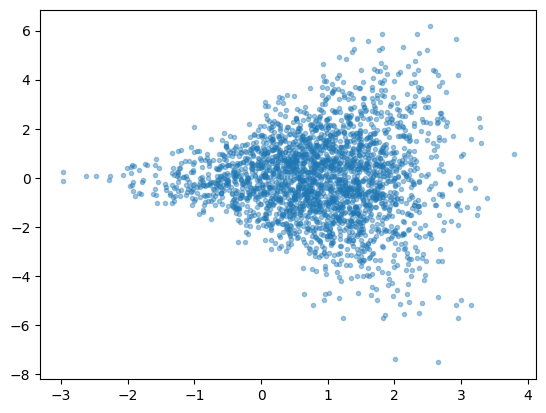

In [8]:
import matplotlib.pyplot as plt

# ode_targ = results_dict["aug_ode"][:, -1,:2]
sde_targ = results_dict["aug"][:, -1,:2]

# plt.plot(ode_targ[:, 0], ode_targ[:, 1], ".", alpha=0.4)
plt.plot(sde_targ[:, 0], sde_targ[:, 1], ".", alpha=0.4)

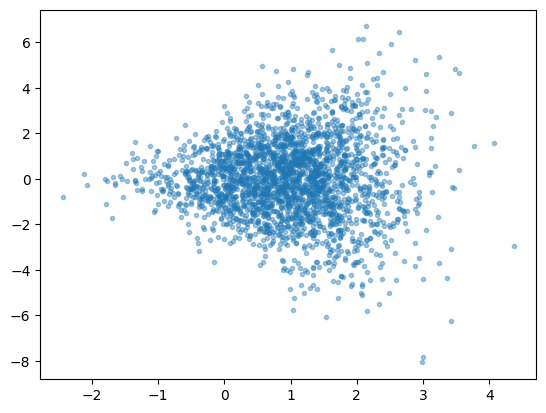

In [9]:
timestep = 90

sde_targ2 = results_dict["aug"][:, timestep,:2]

# plt.plot(ode_targ[:, 0], ode_targ[:, 1], ".", alpha=0.4)
plt.plot(sde_targ2[:, 0], sde_targ2[:, 1], ".", alpha=0.4)

In [10]:
jnp.array(results_dict["is_eval"]).mean()

DeviceArray(0.19644699, dtype=float32)

In [11]:
results_dict["is_eval"]

[0.34063243865966797,
 0.25713634490966797,
 0.31430959701538086,
 0.48174476623535156,
 0.2250523567199707,
 -1.5691299438476562,
 -0.6257877349853516,
 0.42383480072021484,
 0.3949127197265625,
 0.5222587585449219,
 0.3555917739868164,
 0.5387654304504395,
 0.44716835021972656,
 0.547816276550293,
 0.4117445945739746,
 0.47664928436279297,
 0.25286388397216797,
 0.3381776809692383,
 0.5147247314453125,
 0.3649134635925293,
 0.5430974960327148,
 0.6279191970825195,
 -1.8769865036010742,
 -0.03333568572998047,
 0.6560783386230469,
 0.3731260299682617,
 -0.08646774291992188,
 0.1712818145751953,
 0.22766685485839844,
 0.2776498794555664]

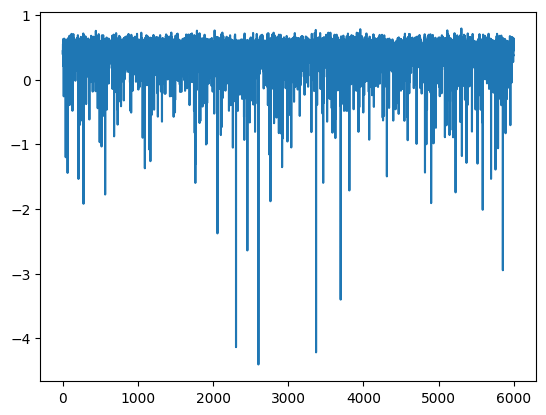

In [12]:
plt.plot(results_dict["is"])

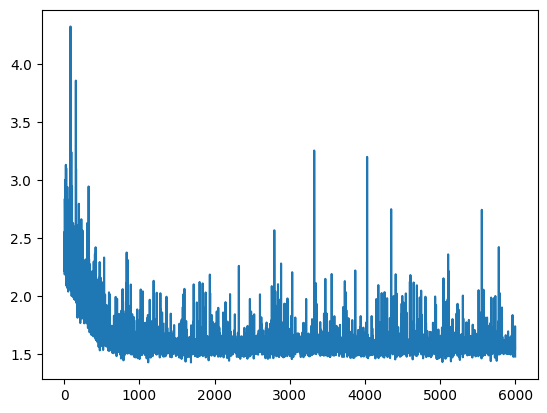

In [13]:
plt.plot(results_dict["elbo"])

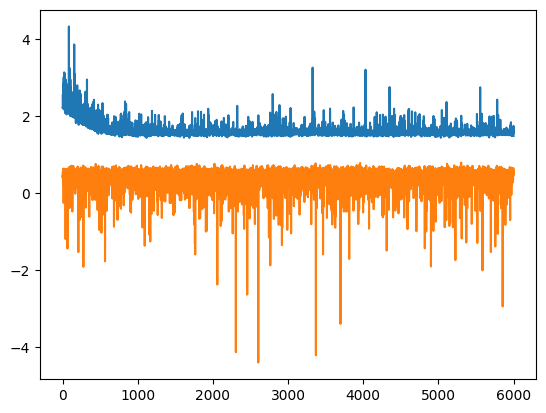

In [14]:
plt.plot(results_dict["elbo"])
plt.plot(results_dict["is"])

In [15]:
jnp.array(results_dict["elbo_eval"]).mean()

DeviceArray(1.5899235, dtype=float32)